In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

# Define METAINFO
METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0, 0, 0),
        (230, 25, 75),
        (60, 180, 75),
        (255, 225, 25),
        (0, 130, 200),
        (145, 30, 180),
        (70, 240, 240),
        (240, 50, 230),
        (210, 245, 60),
        (250, 190, 190),
        (0, 128, 128),
        (170, 110, 40),
        (255, 250, 200),
        (128, 0, 0),
        (170, 255, 195),
        (128, 128, 0),
        (255, 215, 180),
        (0, 0, 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Define label to RGB function
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

In [7]:
import pickle

with open('last_prediction.pkl', 'rb') as f:
    prediction = pickle.load(f)

with open('last_image.pkl', 'rb') as f:
    image = pickle.load(f)

(-0.5, 255.5, 255.5, -0.5)

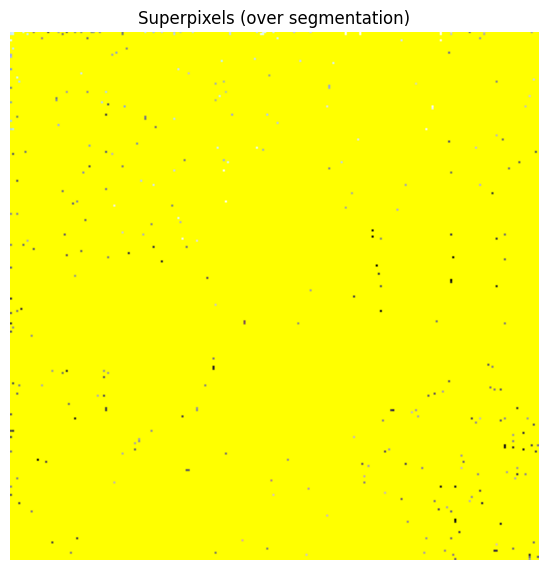

In [17]:
from skimage.segmentation import slic, mark_boundaries

segments = slic(image, n_segments=15000, compactness=10, start_label=1)
superpixel_img = mark_boundaries(image, segments)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(superpixel_img)
plt.title("Superpixels (over segmentation)")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

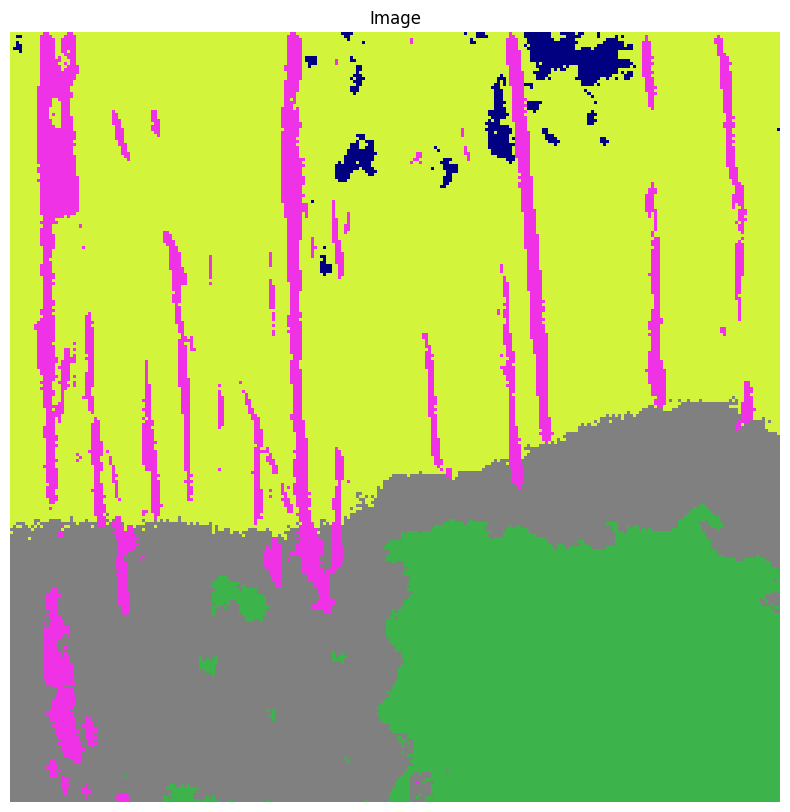

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(label_to_rgb(loaded_prediction, METAINFO['palette']))
plt.title("Image")
plt.axis('off')



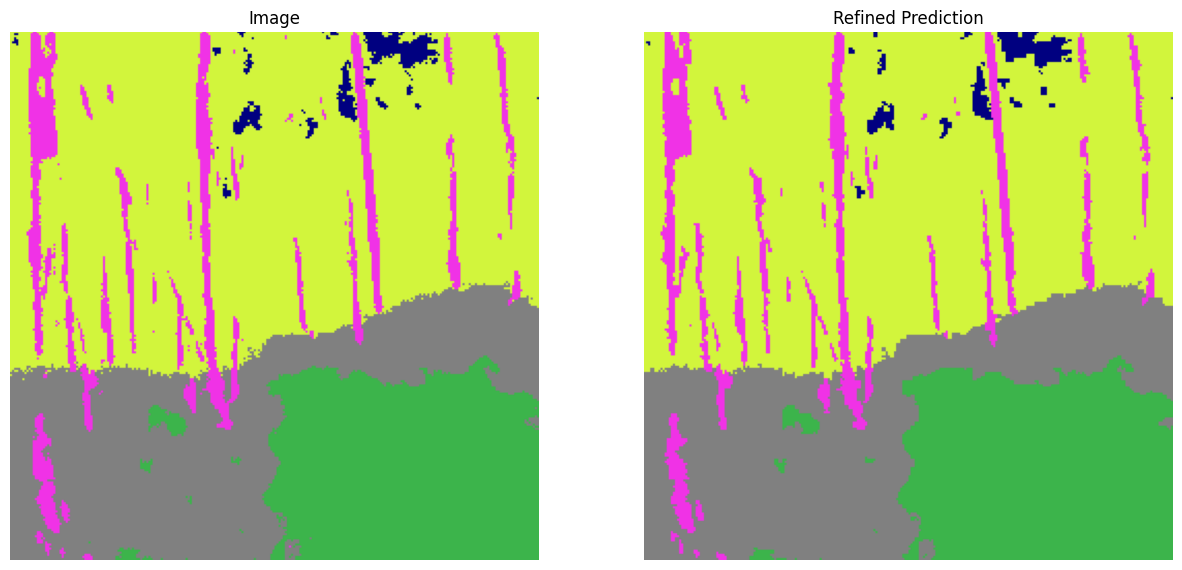

In [20]:
# input image: image
# segmentation: prediction

# apply SLIC to segment the whole image into K superpixels: segments

prediction_new = prediction_colours.copy()

# for each segment
for segment in np.unique(segments):
    N = np.count_nonzero(segment)
    
    # count number of features in segment
    mask = segments == segment
    segment_colours = prediction_colours[mask]
    colour_tuples = [tuple(colour) for colour in segment_colours.reshape(-1, 3)]
    num_features = len(colour_tuples)

    weights = {}

    # initialise all weights with 0
    for tup in colour_tuples:
        weights[tup] = 0
    
    # use M = {C1, C2, ..., CN} refers to all pixels in this segment
        # Cj has classification j
    # get feature of each pixel in C
    # initialise weight Wc with 0

    # for each pixel:
    for p in segment_colours.reshape(-1, 3):
        pixel = tuple(p)
        # Wcj = oldWcj + 1/N
        weights[pixel] += (1 / num_features)

        # if Wcj > 0.8, exit this inner loop
        if (weights[pixel] > 0.8):
            break

    # search for Wc
    # search maximum Wmax and submaximum Wsub
    curr_max = 0
    max_label = colour_tuples[0]
    for label in weights:
        if weights[label] > curr_max:
            curr_max = weights[label]
            max_label = label

    curr_sub = 0
    sub_max_label = colour_tuples[0]
    for label in weights:
        if weights[label] > curr_sub:
            if label != max_label:
                curr_sub = weights[label]
                sub_max_label = label

    # if Wmax - Wsub > 0.2, move onto next step
    if (sub_max_label != max_label and  curr_max - curr_sub > 0.2): # i changed threshold to 0.1 because it was too 'pixelaed'
        # reassign classification of current superpixel with LCmax
        prediction_new[mask] = max_label

# output new segmentation
plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.imshow(prediction_new)
plt.title("Refined Prediction")
plt.axis('off')
plt.subplot(121)
plt.imshow(label_to_rgb(loaded_prediction, METAINFO['palette']))
plt.title("Image")
plt.axis('off')
plt.show()